# LogisticBART Grid Search Analysis: Multiple Parameter Combinations

This notebook performs a comprehensive grid search analysis of LogisticBART performance across different combinations of:
- `bart_num` (number of chains)
- `TOTAL_BUDGET` (total computational budget)
- `RATIO_TARGET` (ratio of n_post/n_skip)

Results are visualized as colored heatmaps showing Accuracy and Log Loss performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder, normalize
from bart_playground import *
from bart_playground.bart import LogisticBART
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Grid search parameters
BART_NUMS = [1, 2, 3, 4]
TOTAL_BUDGETS = [120, 160, 240]
RATIO_TARGETS = [0.05, 0.1, 0.25, 1, 4, 10, 20]

# Fixed parameters
N_TREES = 50  # Reduced for faster computation
RANDOM_STATE = 42
PROPOSAL_PROBS = {"grow": 0.4, "prune": 0.4, "change": 0.1, "swap": 0.1}

np.random.seed(RANDOM_STATE)

print(f"Grid search dimensions:")
print(f"BART_NUMS: {len(BART_NUMS)} values {BART_NUMS}")
print(f"TOTAL_BUDGETS: {len(TOTAL_BUDGETS)} values {TOTAL_BUDGETS}")
print(f"RATIO_TARGETS: {len(RATIO_TARGETS)} values {RATIO_TARGETS}")
print(f"Total combinations: {len(BART_NUMS) * len(TOTAL_BUDGETS) * len(RATIO_TARGETS)}")

Grid search dimensions:
BART_NUMS: 4 values [1, 2, 3, 4]
TOTAL_BUDGETS: 3 values [120, 160, 240]
RATIO_TARGETS: 7 values [0.05, 0.1, 0.25, 1, 4, 10, 20]
Total combinations: 84


In [3]:
def load_mushroom():
    X, y = fetch_openml('mushroom', version=1, return_X_y=True)
    for col in X.select_dtypes('category'):
        # -1 in codes indicates NaN by pandas convention
        X[col] = X[col].cat.codes
    X = normalize(X)
    y_array = y.to_numpy().reshape(-1, 1)
    y_arm = OrdinalEncoder(dtype=int).fit_transform(y_array).flatten()
    
    # make the dataset a little bit smaller
    indices = np.random.choice(X.shape[0], size=2000, replace=False)
    X = X[indices, :]
    y_arm = y_arm[indices]
    
    return X, y_arm

def load_mushroom_encoded():
    X, y_arm = load_mushroom()
    
    n_arm = np.max(y_arm) + 1
    dim = X.shape[1] * n_arm # total number of encoded covariates (location-encoded for each arm) 
    act_dim = X.shape[1] # number of covariates
    covariates = np.zeros((X.shape[0], dim))
    rewards = np.zeros((X.shape[0], ))
    for cursor in range(X.shape[0]):
        a = np.random.randint(0, n_arm)
        covariates[cursor, a * act_dim:(a * act_dim + act_dim)] = X[cursor]
        if y_arm[cursor] == a:
            rewards[cursor] = 1 # reward is 1 if the true category matches the chosen arm

    return covariates, rewards

In [4]:
from joblib import Parallel, delayed

def fit_and_get_probs(seed, X_train, y_train, X_test,
                      n_trees, ndpost, nskip, proposal_probs):
    # Initialize with a reproducible random state
    model = LogisticBART(
        n_trees=n_trees,
        ndpost=ndpost,
        nskip=nskip,
        proposal_probs=proposal_probs,
        random_state=seed
    )
    # Heavy CPU work: fit and predict
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)
    # Return the positive‐class probabilities
    return proba[:, 1]

def evaluate_logistic_bart(bart_num, total_budget, ratio_target, X_train, X_test, y_train, y_test):
    """Evaluate LogisticBART with given parameters"""
    
    # Calculate n_post and n_skip
    total_per_bart = total_budget // bart_num
    n_skip = int(total_per_bart / (ratio_target + 1))
    n_post = total_per_bart - n_skip
    
    # Skip invalid configurations
    if n_post <= 0 or n_skip <= 0:
        return None
    
    try:
        # Initialize arrays for predictions
        all_probs = Parallel(n_jobs=-1)(
            delayed(fit_and_get_probs)(
                i, X_train, y_train, X_test,
                N_TREES, n_post, n_skip, PROPOSAL_PROBS
            )
            for i in range(bart_num)
        )
        
        # Average probabilities across chains
        y_pred_prob = np.mean(all_probs, axis=0)
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        logloss = log_loss(y_test, y_pred_prob)
        
        return {
            'bart_num': bart_num,
            'total_budget': total_budget,
            'ratio_target': ratio_target,
            'n_post': n_post,
            'n_skip': n_skip,
            'accuracy': accuracy,
            'log_loss': logloss,
            'actual_budget': (n_post + n_skip) * bart_num
        }
        
    except Exception as e:
        print(f"Error with bart_num={bart_num}, budget={total_budget}, ratio={ratio_target}: {e}")
        return None

In [5]:
# Load and prepare data
print("Loading Mushroom Encoded dataset...")
X, y = load_mushroom_encoded()

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"y distribution: {pd.Series(y).value_counts(normalize=True).to_dict()}")

# Split data with smaller training set for faster computation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Loading Mushroom Encoded dataset...
Dataset shape: X=(2000, 44), y=(2000,)
y distribution: {0.0: 0.513, 1.0: 0.487}
Training set: 400 samples
Test set: 1600 samples


In [6]:
# Perform grid search
print("\n=== Starting Grid Search ===")
results = []
total_combinations = len(BART_NUMS) * len(TOTAL_BUDGETS) * len(RATIO_TARGETS)
current_combination = 0

start_time = time.time()

for bart_num, total_budget, ratio_target in product(BART_NUMS, TOTAL_BUDGETS, RATIO_TARGETS):
    current_combination += 1
    
    print(f"Progress: {current_combination}/{total_combinations} - "
          f"bart_num={bart_num}, budget={total_budget}, ratio={ratio_target}")
    
    result = evaluate_logistic_bart(bart_num, total_budget, ratio_target, 
                                   X_train, X_test, y_train, y_test)
    
    if result is not None:
        results.append(result)

total_time = time.time() - start_time
print(f"\nGrid search completed in {total_time:.2f} seconds")
print(f"Valid configurations: {len(results)}/{total_combinations}")


=== Starting Grid Search ===
Progress: 1/84 - bart_num=1, budget=120, ratio=0.05


Iterations: 100%|██████████| 120/120 [00:04<00:00, 28.10it/s]


Progress: 2/84 - bart_num=1, budget=120, ratio=0.1


Iterations: 100%|██████████| 120/120 [00:04<00:00, 29.09it/s]


Progress: 3/84 - bart_num=1, budget=120, ratio=0.25


Iterations: 100%|██████████| 120/120 [00:04<00:00, 29.14it/s]


Progress: 4/84 - bart_num=1, budget=120, ratio=1


Iterations: 100%|██████████| 120/120 [00:04<00:00, 29.64it/s]


Progress: 5/84 - bart_num=1, budget=120, ratio=4


Iterations: 100%|██████████| 120/120 [00:04<00:00, 29.08it/s]


Progress: 6/84 - bart_num=1, budget=120, ratio=10


Iterations: 100%|██████████| 120/120 [00:04<00:00, 29.36it/s]


Progress: 7/84 - bart_num=1, budget=120, ratio=20


Iterations: 100%|██████████| 120/120 [00:04<00:00, 29.59it/s]


Progress: 8/84 - bart_num=1, budget=160, ratio=0.05


Iterations:   5%|▌         | 8/160 [00:00<00:01, 78.40it/s]

Progress: 9/84 - bart_num=1, budget=160, ratio=0.1


Iterations: 100%|██████████| 160/160 [00:02<00:00, 59.07it/s]


Progress: 10/84 - bart_num=1, budget=160, ratio=0.25


Iterations: 100%|██████████| 160/160 [00:02<00:00, 56.06it/s]


Progress: 11/84 - bart_num=1, budget=160, ratio=1


Iterations: 100%|██████████| 160/160 [00:02<00:00, 58.11it/s]


Progress: 12/84 - bart_num=1, budget=160, ratio=4


Iterations: 100%|██████████| 160/160 [00:02<00:00, 59.47it/s]


Progress: 13/84 - bart_num=1, budget=160, ratio=10


Iterations: 100%|██████████| 160/160 [00:02<00:00, 59.61it/s]


Progress: 14/84 - bart_num=1, budget=160, ratio=20


Iterations: 100%|██████████| 160/160 [00:02<00:00, 59.70it/s]


Progress: 15/84 - bart_num=1, budget=240, ratio=0.05


Iterations:   0%|          | 0/240 [00:00<?, ?it/s]

Progress: 16/84 - bart_num=1, budget=240, ratio=0.1


Iterations: 100%|██████████| 240/240 [00:04<00:00, 58.35it/s]


Progress: 17/84 - bart_num=1, budget=240, ratio=0.25


Iterations: 100%|██████████| 240/240 [00:04<00:00, 58.77it/s]


Progress: 18/84 - bart_num=1, budget=240, ratio=1


Iterations: 100%|██████████| 240/240 [00:04<00:00, 57.99it/s]


Progress: 19/84 - bart_num=1, budget=240, ratio=4


Iterations: 100%|██████████| 240/240 [00:04<00:00, 57.45it/s]


Progress: 20/84 - bart_num=1, budget=240, ratio=10


Iterations: 100%|██████████| 240/240 [00:04<00:00, 59.50it/s]


Progress: 21/84 - bart_num=1, budget=240, ratio=20


Iterations: 100%|██████████| 240/240 [00:04<00:00, 59.78it/s]


Progress: 22/84 - bart_num=2, budget=120, ratio=0.05


Iterations:   0%|          | 0/60 [00:00<?, ?it/s]

Progress: 23/84 - bart_num=2, budget=120, ratio=0.1


Iterations:  13%|█▎        | 8/60 [00:00<00:00, 72.13it/s]

Progress: 24/84 - bart_num=2, budget=120, ratio=0.25


Iterations:   0%|          | 0/60 [00:00<?, ?it/s]

Progress: 25/84 - bart_num=2, budget=120, ratio=1


Iterations: 100%|██████████| 60/60 [00:01<00:00, 54.30it/s]


Progress: 26/84 - bart_num=2, budget=120, ratio=4


Iterations: 100%|██████████| 60/60 [00:01<00:00, 57.47it/s]


Progress: 27/84 - bart_num=2, budget=120, ratio=10


Iterations: 100%|██████████| 60/60 [00:01<00:00, 57.40it/s]


Progress: 28/84 - bart_num=2, budget=120, ratio=20


Iterations: 100%|██████████| 60/60 [00:01<00:00, 56.77it/s]


Progress: 29/84 - bart_num=2, budget=160, ratio=0.05


Iterations:  10%|█         | 8/80 [00:00<00:00, 73.23it/s]

Progress: 30/84 - bart_num=2, budget=160, ratio=0.1


Iterations:   9%|▉         | 7/80 [00:00<00:01, 64.84it/s]

Progress: 31/84 - bart_num=2, budget=160, ratio=0.25


Iterations:   0%|          | 0/80 [00:00<?, ?it/s]

Progress: 32/84 - bart_num=2, budget=160, ratio=1


Iterations: 100%|██████████| 80/80 [00:01<00:00, 57.51it/s]


Progress: 33/84 - bart_num=2, budget=160, ratio=4


Iterations: 100%|██████████| 80/80 [00:01<00:00, 56.35it/s]


Progress: 34/84 - bart_num=2, budget=160, ratio=10


Iterations: 100%|██████████| 80/80 [00:01<00:00, 53.96it/s]


Progress: 35/84 - bart_num=2, budget=160, ratio=20


Iterations: 100%|██████████| 80/80 [00:01<00:00, 54.22it/s]


Progress: 36/84 - bart_num=2, budget=240, ratio=0.05


Iterations: 100%|██████████| 120/120 [00:02<00:00, 52.49it/s]


Progress: 37/84 - bart_num=2, budget=240, ratio=0.1


Iterations: 100%|██████████| 120/120 [00:02<00:00, 53.98it/s]


Progress: 38/84 - bart_num=2, budget=240, ratio=0.25


Iterations: 100%|██████████| 120/120 [00:02<00:00, 47.23it/s]


Progress: 39/84 - bart_num=2, budget=240, ratio=1


Iterations: 100%|██████████| 120/120 [00:02<00:00, 52.93it/s]


Progress: 40/84 - bart_num=2, budget=240, ratio=4


Iterations: 100%|██████████| 120/120 [00:02<00:00, 55.80it/s]


Progress: 41/84 - bart_num=2, budget=240, ratio=10


Iterations: 100%|██████████| 120/120 [00:02<00:00, 55.87it/s]


Progress: 42/84 - bart_num=2, budget=240, ratio=20


Iterations: 100%|██████████| 120/120 [00:02<00:00, 53.37it/s]


Progress: 43/84 - bart_num=3, budget=120, ratio=0.05


Iterations:  18%|█▊        | 7/40 [00:00<00:00, 68.58it/s]

Progress: 44/84 - bart_num=3, budget=120, ratio=0.1


Iterations: 100%|██████████| 40/40 [00:00<00:00, 55.31it/s]


Progress: 45/84 - bart_num=3, budget=120, ratio=0.25


Iterations:  18%|█▊        | 7/40 [00:00<00:00, 69.05it/s]

Progress: 46/84 - bart_num=3, budget=120, ratio=1


Iterations: 100%|██████████| 40/40 [00:00<00:00, 53.74it/s]


Progress: 47/84 - bart_num=3, budget=120, ratio=4


Iterations: 100%|██████████| 40/40 [00:00<00:00, 53.64it/s]


Progress: 48/84 - bart_num=3, budget=120, ratio=10


Iterations: 100%|██████████| 40/40 [00:00<00:00, 53.09it/s]


Progress: 49/84 - bart_num=3, budget=120, ratio=20


Iterations: 100%|██████████| 40/40 [00:00<00:00, 54.38it/s]


Progress: 50/84 - bart_num=3, budget=160, ratio=0.05


Iterations:   0%|          | 0/53 [00:00<?, ?it/s]

Progress: 51/84 - bart_num=3, budget=160, ratio=0.1


Iterations:   0%|          | 0/53 [00:00<?, ?it/s]

Progress: 52/84 - bart_num=3, budget=160, ratio=0.25


Iterations: 100%|██████████| 53/53 [00:00<00:00, 53.77it/s]


Progress: 53/84 - bart_num=3, budget=160, ratio=1


Iterations: 100%|██████████| 53/53 [00:00<00:00, 53.84it/s]


Progress: 54/84 - bart_num=3, budget=160, ratio=4


Iterations: 100%|██████████| 53/53 [00:01<00:00, 52.81it/s]


Progress: 55/84 - bart_num=3, budget=160, ratio=10


Iterations: 100%|██████████| 53/53 [00:00<00:00, 54.33it/s]


Progress: 56/84 - bart_num=3, budget=160, ratio=20


Iterations: 100%|██████████| 53/53 [00:00<00:00, 54.74it/s]


Progress: 57/84 - bart_num=3, budget=240, ratio=0.05


Iterations:   0%|          | 0/80 [00:00<?, ?it/s]

Progress: 58/84 - bart_num=3, budget=240, ratio=0.1


Iterations:   0%|          | 0/80 [00:00<?, ?it/s]

Progress: 59/84 - bart_num=3, budget=240, ratio=0.25


Iterations:   0%|          | 0/80 [00:00<?, ?it/s]

Progress: 60/84 - bart_num=3, budget=240, ratio=1


Iterations: 100%|██████████| 80/80 [00:01<00:00, 53.48it/s]


Progress: 61/84 - bart_num=3, budget=240, ratio=4


Iterations: 100%|██████████| 80/80 [00:01<00:00, 53.44it/s]


Progress: 62/84 - bart_num=3, budget=240, ratio=10


Iterations: 100%|██████████| 80/80 [00:01<00:00, 54.43it/s]


Progress: 63/84 - bart_num=3, budget=240, ratio=20


Iterations: 100%|██████████| 80/80 [00:01<00:00, 56.11it/s]


Progress: 64/84 - bart_num=4, budget=120, ratio=0.05


Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

Progress: 65/84 - bart_num=4, budget=120, ratio=0.1


Iterations: 100%|██████████| 30/30 [00:00<00:00, 42.06it/s]


Progress: 66/84 - bart_num=4, budget=120, ratio=0.25


Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

Progress: 67/84 - bart_num=4, budget=120, ratio=1


Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

Progress: 68/84 - bart_num=4, budget=120, ratio=4


Iterations: 100%|██████████| 30/30 [00:00<00:00, 35.18it/s]


Progress: 69/84 - bart_num=4, budget=120, ratio=10


Iterations: 100%|██████████| 30/30 [00:00<00:00, 34.26it/s]


Progress: 70/84 - bart_num=4, budget=120, ratio=20


Iterations: 100%|██████████| 30/30 [00:00<00:00, 36.58it/s]


Progress: 71/84 - bart_num=4, budget=160, ratio=0.05


Iterations: 100%|██████████| 40/40 [00:01<00:00, 37.32it/s]


Progress: 72/84 - bart_num=4, budget=160, ratio=0.1


Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Progress: 73/84 - bart_num=4, budget=160, ratio=0.25


Iterations:  12%|█▎        | 5/40 [00:00<00:00, 42.93it/s]

Progress: 74/84 - bart_num=4, budget=160, ratio=1


Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Progress: 75/84 - bart_num=4, budget=160, ratio=4


Iterations: 100%|██████████| 40/40 [00:01<00:00, 35.70it/s]


Progress: 76/84 - bart_num=4, budget=160, ratio=10


Iterations: 100%|██████████| 40/40 [00:01<00:00, 34.11it/s]


Progress: 77/84 - bart_num=4, budget=160, ratio=20


Iterations: 100%|██████████| 40/40 [00:01<00:00, 36.27it/s]


Progress: 78/84 - bart_num=4, budget=240, ratio=0.05


Iterations:   0%|          | 0/60 [00:00<?, ?it/s]

Progress: 79/84 - bart_num=4, budget=240, ratio=0.1


Iterations:   0%|          | 0/60 [00:00<?, ?it/s]

Progress: 80/84 - bart_num=4, budget=240, ratio=0.25


Iterations: 100%|██████████| 60/60 [00:01<00:00, 37.23it/s]


Progress: 81/84 - bart_num=4, budget=240, ratio=1


Iterations: 100%|██████████| 60/60 [00:01<00:00, 36.55it/s]


Progress: 82/84 - bart_num=4, budget=240, ratio=4


Iterations: 100%|██████████| 60/60 [00:01<00:00, 34.47it/s]


Progress: 83/84 - bart_num=4, budget=240, ratio=10


Iterations: 100%|██████████| 60/60 [00:01<00:00, 35.05it/s]


Progress: 84/84 - bart_num=4, budget=240, ratio=20


Iterations: 100%|██████████| 60/60 [00:01<00:00, 35.97it/s]



Grid search completed in 190.08 seconds
Valid configurations: 84/84


In [7]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("\n=== Grid Search Results Summary ===")
print(f"Total valid configurations: {len(results_df)}")
print(f"Accuracy range: {results_df['accuracy'].min():.4f} - {results_df['accuracy'].max():.4f}")
print(f"Log Loss range: {results_df['log_loss'].min():.4f} - {results_df['log_loss'].max():.4f}")

print("\nBest configurations:")
best_accuracy = results_df.loc[results_df['accuracy'].idxmax()]
best_logloss = results_df.loc[results_df['log_loss'].idxmin()]

print(f"Best Accuracy: {best_accuracy['accuracy']:.4f}")
print(f"  bart_num={best_accuracy['bart_num']}, budget={best_accuracy['total_budget']}, ratio={best_accuracy['ratio_target']}")

print(f"Best Log Loss: {best_logloss['log_loss']:.4f}")
print(f"  bart_num={best_logloss['bart_num']}, budget={best_logloss['total_budget']}, ratio={best_logloss['ratio_target']}")


=== Grid Search Results Summary ===
Total valid configurations: 84
Accuracy range: 0.8975 - 0.9319
Log Loss range: 0.2330 - 0.2794

Best configurations:
Best Accuracy: 0.9319
  bart_num=3.0, budget=240.0, ratio=0.05
Best Log Loss: 0.2330
  bart_num=4.0, budget=160.0, ratio=0.05


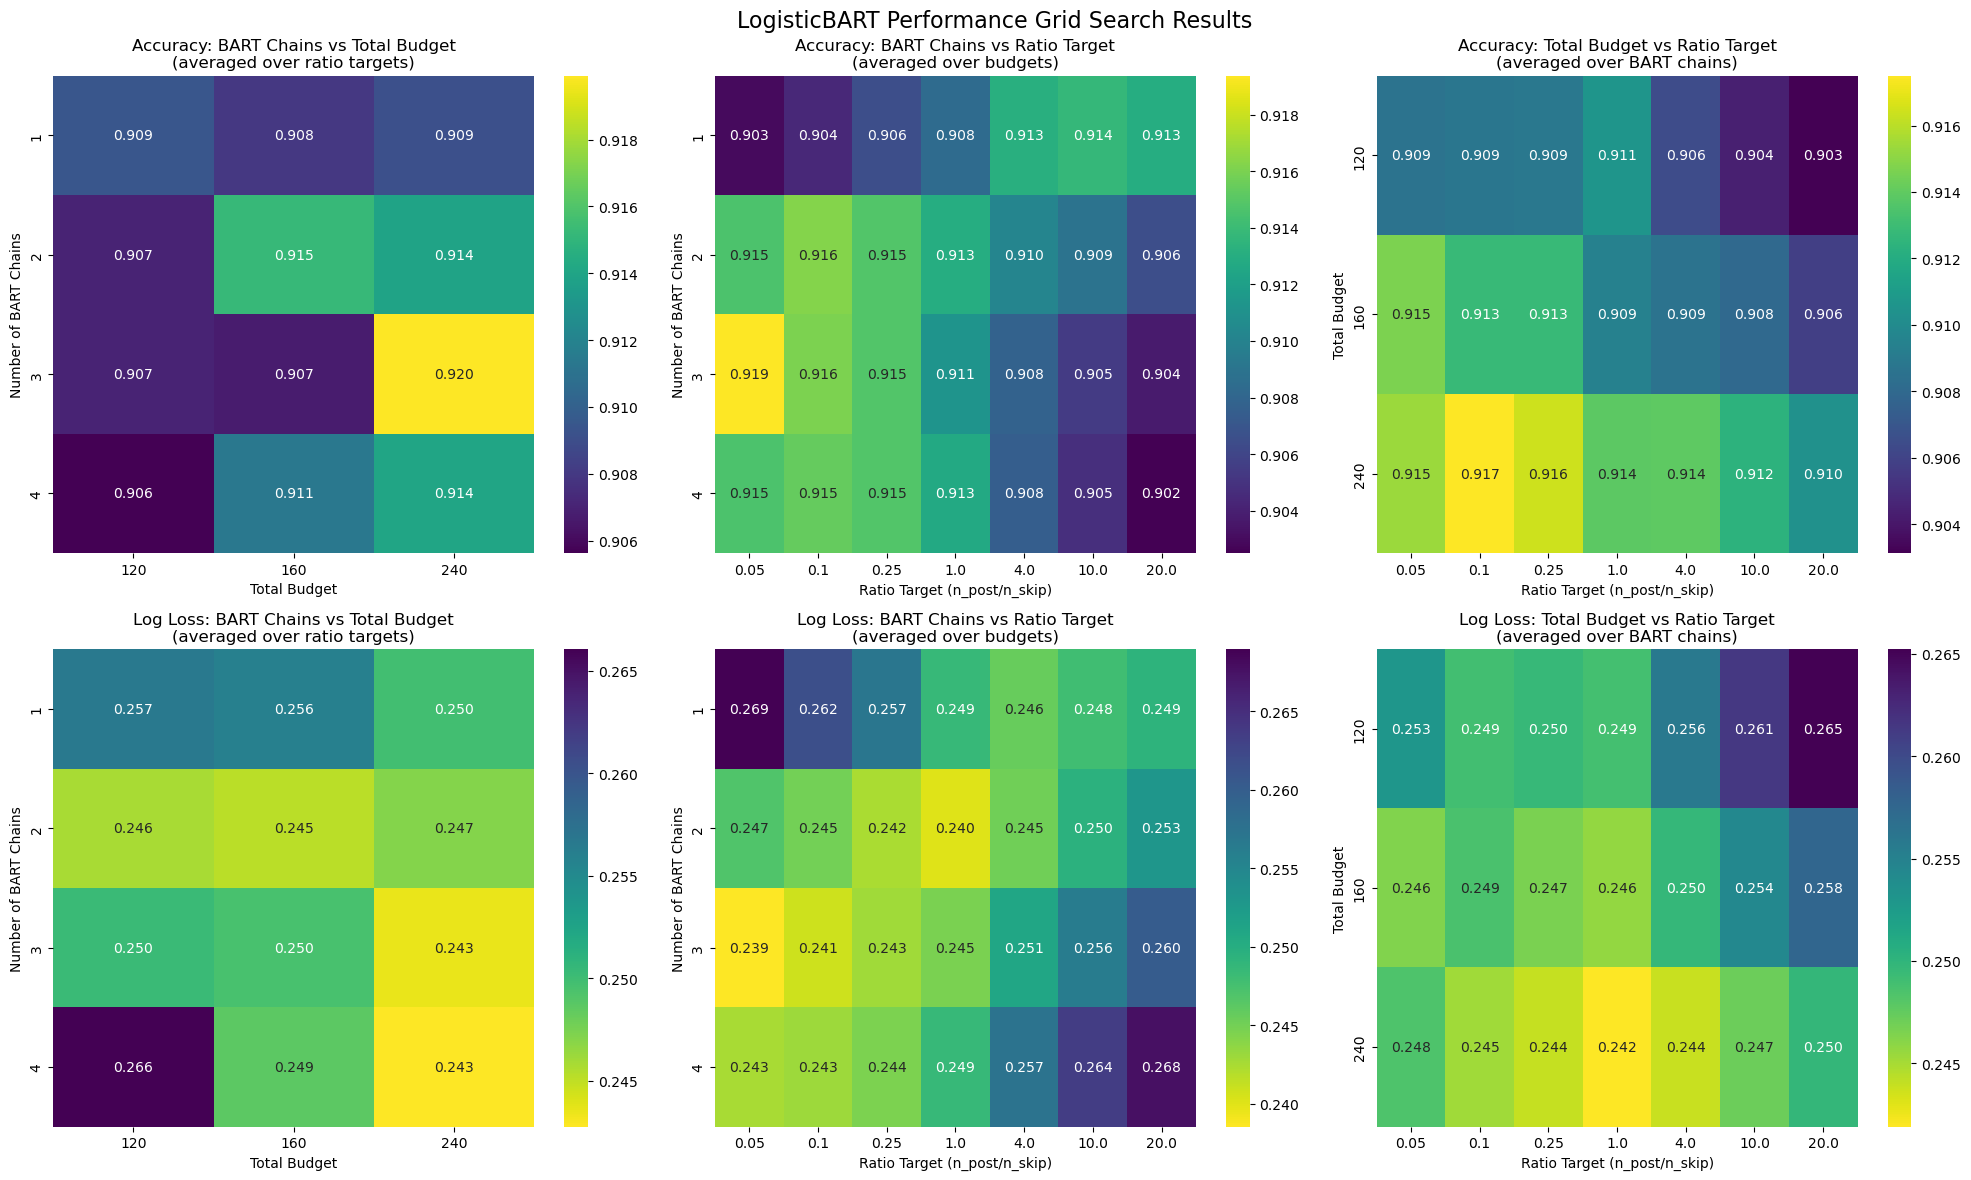

In [8]:
# Create heatmaps for different perspectives
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('LogisticBART Performance Grid Search Results', fontsize=16)

# 1. Accuracy: bart_num vs total_budget (averaged over ratio_target)
acc_pivot1 = results_df.groupby(['bart_num', 'total_budget'])['accuracy'].mean().unstack()
sns.heatmap(acc_pivot1, annot=True, fmt='.3f', cmap='viridis', ax=axes[0,0])
axes[0,0].set_title('Accuracy: BART Chains vs Total Budget\n(averaged over ratio targets)')
axes[0,0].set_xlabel('Total Budget')
axes[0,0].set_ylabel('Number of BART Chains')

# 2. Log Loss: bart_num vs total_budget (averaged over ratio_target)
loss_pivot1 = results_df.groupby(['bart_num', 'total_budget'])['log_loss'].mean().unstack()
sns.heatmap(loss_pivot1, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[1,0])
axes[1,0].set_title('Log Loss: BART Chains vs Total Budget\n(averaged over ratio targets)')
axes[1,0].set_xlabel('Total Budget')
axes[1,0].set_ylabel('Number of BART Chains')

# 3. Accuracy: bart_num vs ratio_target (averaged over total_budget)
acc_pivot2 = results_df.groupby(['bart_num', 'ratio_target'])['accuracy'].mean().unstack()
sns.heatmap(acc_pivot2, annot=True, fmt='.3f', cmap='viridis', ax=axes[0,1])
axes[0,1].set_title('Accuracy: BART Chains vs Ratio Target\n(averaged over budgets)')
axes[0,1].set_xlabel('Ratio Target (n_post/n_skip)')
axes[0,1].set_ylabel('Number of BART Chains')

# 4. Log Loss: bart_num vs ratio_target (averaged over total_budget)
loss_pivot2 = results_df.groupby(['bart_num', 'ratio_target'])['log_loss'].mean().unstack()
sns.heatmap(loss_pivot2, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[1,1])
axes[1,1].set_title('Log Loss: BART Chains vs Ratio Target\n(averaged over budgets)')
axes[1,1].set_xlabel('Ratio Target (n_post/n_skip)')
axes[1,1].set_ylabel('Number of BART Chains')

# 5. Accuracy: total_budget vs ratio_target (averaged over bart_num)
acc_pivot3 = results_df.groupby(['total_budget', 'ratio_target'])['accuracy'].mean().unstack()
sns.heatmap(acc_pivot3, annot=True, fmt='.3f', cmap='viridis', ax=axes[0,2])
axes[0,2].set_title('Accuracy: Total Budget vs Ratio Target\n(averaged over BART chains)')
axes[0,2].set_xlabel('Ratio Target (n_post/n_skip)')
axes[0,2].set_ylabel('Total Budget')

# 6. Log Loss: total_budget vs ratio_target (averaged over bart_num)
loss_pivot3 = results_df.groupby(['total_budget', 'ratio_target'])['log_loss'].mean().unstack()
sns.heatmap(loss_pivot3, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[1,2])
axes[1,2].set_title('Log Loss: Total Budget vs Ratio Target\n(averaged over BART chains)')
axes[1,2].set_xlabel('Ratio Target (n_post/n_skip)')
axes[1,2].set_ylabel('Total Budget')

plt.tight_layout()
plt.show()

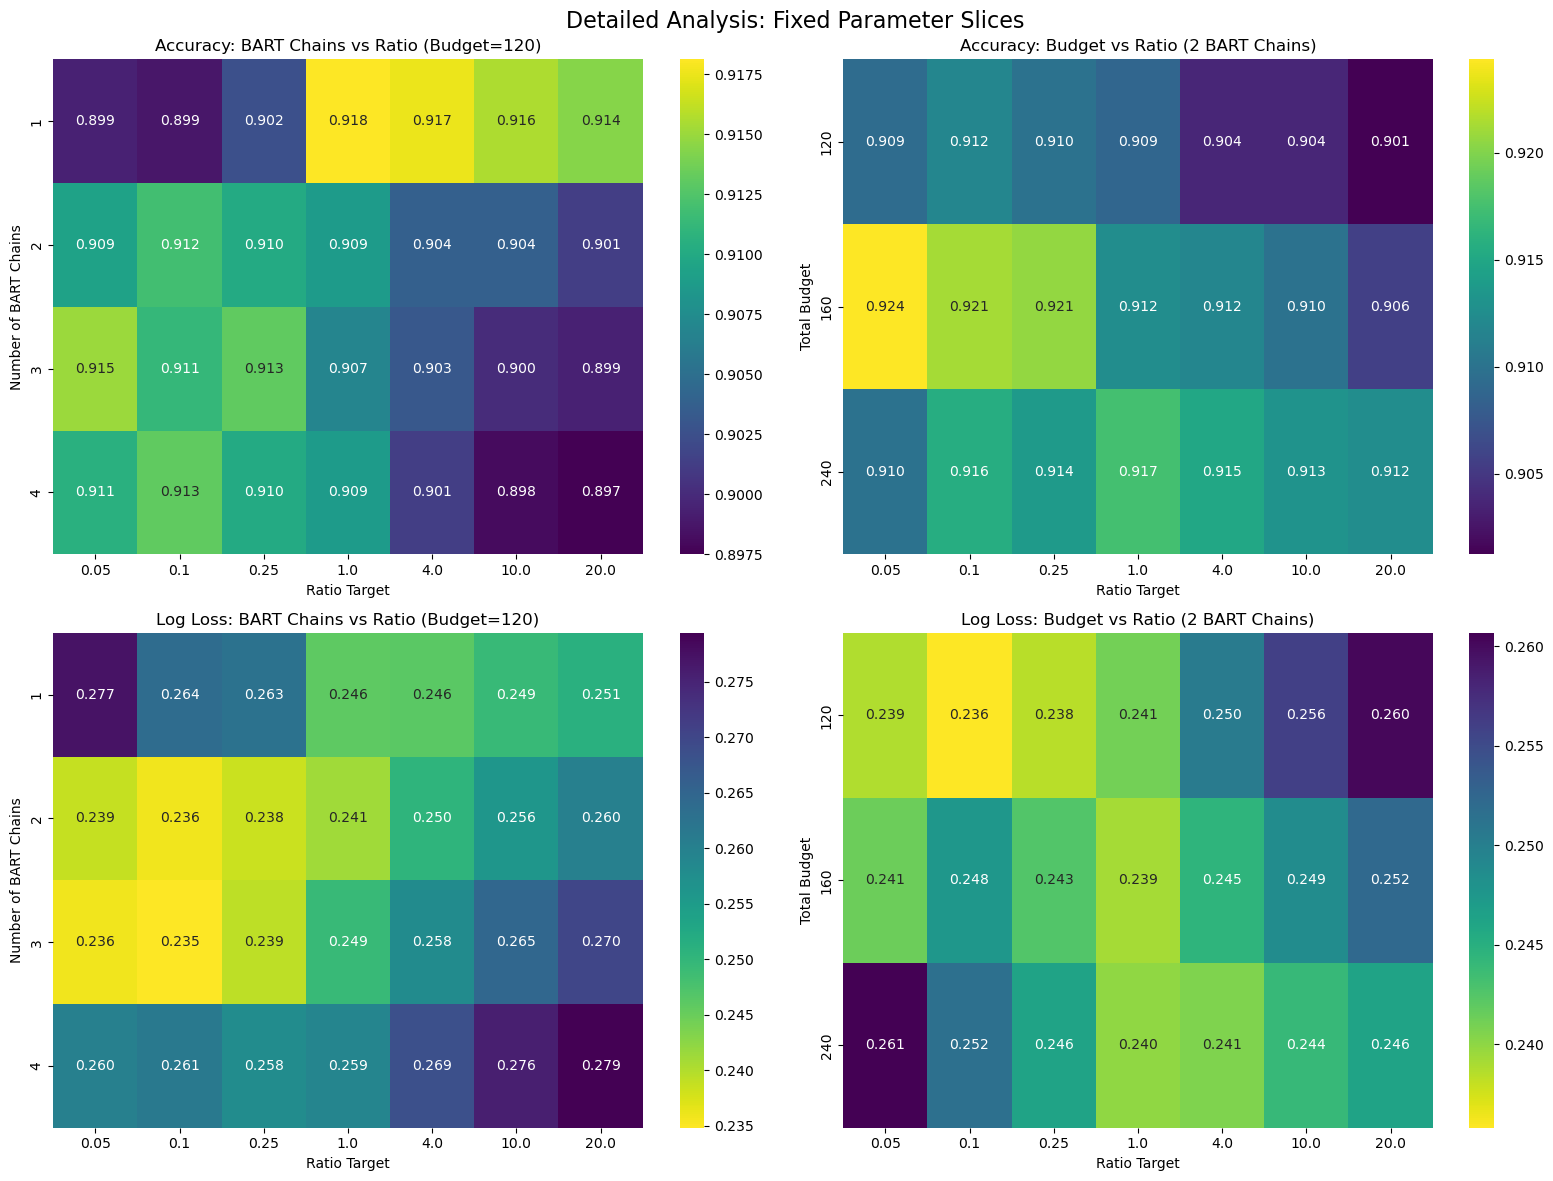

In [9]:
# Create detailed analysis plots for specific parameter values
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Detailed Analysis: Fixed Parameter Slices', fontsize=16)

# Fix total_budget=120 and show bart_num vs ratio_target
budget_fixed = 120
subset1 = results_df[results_df['total_budget'] == budget_fixed]
acc_detail1 = subset1.pivot(index='bart_num', columns='ratio_target', values='accuracy')
loss_detail1 = subset1.pivot(index='bart_num', columns='ratio_target', values='log_loss')

sns.heatmap(acc_detail1, annot=True, fmt='.3f', cmap='viridis', ax=axes[0,0])
axes[0,0].set_title(f'Accuracy: BART Chains vs Ratio (Budget={budget_fixed})')
axes[0,0].set_xlabel('Ratio Target')
axes[0,0].set_ylabel('Number of BART Chains')

sns.heatmap(loss_detail1, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[1,0])
axes[1,0].set_title(f'Log Loss: BART Chains vs Ratio (Budget={budget_fixed})')
axes[1,0].set_xlabel('Ratio Target')
axes[1,0].set_ylabel('Number of BART Chains')

# Fix bart_num=2 and show total_budget vs ratio_target
bart_fixed = 2
subset2 = results_df[results_df['bart_num'] == bart_fixed]
acc_detail2 = subset2.pivot(index='total_budget', columns='ratio_target', values='accuracy')
loss_detail2 = subset2.pivot(index='total_budget', columns='ratio_target', values='log_loss')

sns.heatmap(acc_detail2, annot=True, fmt='.3f', cmap='viridis', ax=axes[0,1])
axes[0,1].set_title(f'Accuracy: Budget vs Ratio ({bart_fixed} BART Chains)')
axes[0,1].set_xlabel('Ratio Target')
axes[0,1].set_ylabel('Total Budget')

sns.heatmap(loss_detail2, annot=True, fmt='.3f', cmap='viridis_r', ax=axes[1,1])
axes[1,1].set_title(f'Log Loss: Budget vs Ratio ({bart_fixed} BART Chains)')
axes[1,1].set_xlabel('Ratio Target')
axes[1,1].set_ylabel('Total Budget')

plt.tight_layout()
plt.show()

In [10]:
# Statistical analysis
print("\n" + "="*80)
print("STATISTICAL ANALYSIS")
print("="*80)

# Correlation analysis
print("Parameter Correlations with Performance:")
corr_data = results_df[['bart_num', 'total_budget', 'ratio_target', 'accuracy', 'log_loss']]
correlation_matrix = corr_data.corr()

print("\nCorrelation with Accuracy:")
acc_corr = correlation_matrix['accuracy'].sort_values(ascending=False)
for param, corr in acc_corr.items():
    if param != 'accuracy':
        print(f"  {param}: {corr:.4f}")

print("\nCorrelation with Log Loss:")
loss_corr = correlation_matrix['log_loss'].sort_values()
for param, corr in loss_corr.items():
    if param != 'log_loss':
        print(f"  {param}: {corr:.4f}")

# Best performing parameter ranges
print(f"\nTop 10 configurations by Accuracy:")
top_acc = results_df.nlargest(10, 'accuracy')[['bart_num', 'total_budget', 'ratio_target', 'accuracy', 'log_loss']]
print(top_acc.to_string(index=False))

print(f"\nTop 10 configurations by Log Loss (lower is better):")
top_loss = results_df.nsmallest(10, 'log_loss')[['bart_num', 'total_budget', 'ratio_target', 'accuracy', 'log_loss']]
print(top_loss.to_string(index=False))


STATISTICAL ANALYSIS
Parameter Correlations with Performance:

Correlation with Accuracy:
  total_budget: 0.4164
  bart_num: 0.0595
  ratio_target: -0.3304
  log_loss: -0.7411

Correlation with Log Loss:
  accuracy: -0.7411
  total_budget: -0.3283
  bart_num: -0.0334
  ratio_target: 0.3505

Top 10 configurations by Accuracy:
 bart_num  total_budget  ratio_target  accuracy  log_loss
        3           240          0.05  0.931875  0.238300
        3           240          0.10  0.926250  0.244993
        3           240          0.25  0.926250  0.241755
        2           160          0.05  0.924375  0.241422
        2           160          0.10  0.921250  0.247564
        2           160          0.25  0.920625  0.242521
        4           160          0.05  0.919375  0.232973
        4           160          0.25  0.918750  0.237832
        1           120          1.00  0.918125  0.245819
        4           240          1.00  0.918125  0.239253

Top 10 configurations by Log Loss

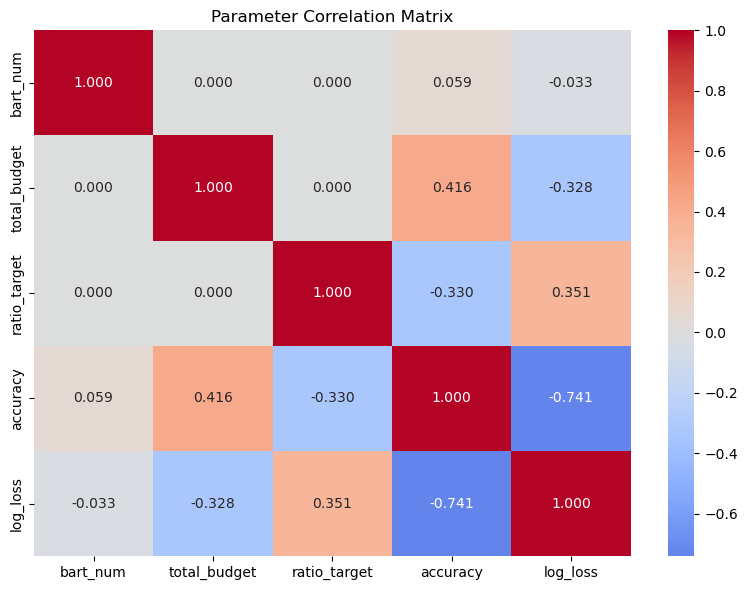

In [11]:
# Create correlation heatmap
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
correlation_matrix = results_df[['bart_num', 'total_budget', 'ratio_target', 'accuracy', 'log_loss']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Parameter Correlation Matrix')
plt.tight_layout()
plt.show()

In [12]:
# Summary insights and recommendations
print("\n" + "="*80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*80)

# Find optimal parameter combinations
best_overall = results_df.loc[results_df['accuracy'].idxmax()]
best_efficiency = results_df.loc[results_df.groupby('actual_budget')['accuracy'].idxmax()]

print("1. BEST OVERALL PERFORMANCE:")
print(f"   Accuracy: {best_overall['accuracy']:.4f}, Log Loss: {best_overall['log_loss']:.4f}")
print(f"   Configuration: bart_num={best_overall['bart_num']}, budget={best_overall['total_budget']}, ratio={best_overall['ratio_target']}")
print(f"   Actual budget used: {best_overall['actual_budget']}")

print("\n2. PARAMETER IMPACT ANALYSIS:")
# Group by each parameter and show impact
for param in ['bart_num', 'total_budget', 'ratio_target']:
    param_impact = results_df.groupby(param)['accuracy'].agg(['mean', 'std']).round(4)
    best_param_value = param_impact['mean'].idxmax()
    print(f"   {param}:")
    print(f"     Best value: {best_param_value} (avg accuracy: {param_impact.loc[best_param_value, 'mean']:.4f})")
    print(f"     Range: {param_impact['mean'].min():.4f} - {param_impact['mean'].max():.4f}")

print("\n3. COMPUTATIONAL EFFICIENCY:")
efficiency_analysis = results_df.groupby('actual_budget')['accuracy'].max().sort_index()
print("   Best accuracy by computational budget:")
for budget, acc in efficiency_analysis.items():
    best_config = results_df[(results_df['actual_budget'] == budget) & (results_df['accuracy'] == acc)].iloc[0]
    print(f"     Budget {budget}: {acc:.4f} (bart_num={best_config['bart_num']}, ratio={best_config['ratio_target']})")

print(f"\n4. TOTAL EXPERIMENTS: {len(results_df)} valid configurations")
print(f"   Grid search completed successfully!")


KEY INSIGHTS AND RECOMMENDATIONS
1. BEST OVERALL PERFORMANCE:
   Accuracy: 0.9319, Log Loss: 0.2383
   Configuration: bart_num=3.0, budget=240.0, ratio=0.05
   Actual budget used: 240.0

2. PARAMETER IMPACT ANALYSIS:
   bart_num:
     Best value: 2 (avg accuracy: 0.9120)
     Range: 0.9088 - 0.9120
   total_budget:
     Best value: 240 (avg accuracy: 0.9142)
     Range: 0.9073 - 0.9142
   ratio_target:
     Best value: 0.1 (avg accuracy: 0.9130)
     Range: 0.9064 - 0.9130

3. COMPUTATIONAL EFFICIENCY:
   Best accuracy by computational budget:
     Budget 120: 0.9181 (bart_num=1.0, ratio=1.0)
     Budget 159: 0.9113 (bart_num=3.0, ratio=0.05)
     Budget 160: 0.9244 (bart_num=2.0, ratio=0.05)
     Budget 240: 0.9319 (bart_num=3.0, ratio=0.05)

4. TOTAL EXPERIMENTS: 84 valid configurations
   Grid search completed successfully!
